In [1]:
import torch
import torch.nn as nn
import pandas as pd 
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import LSTM
from torch.utils.data import DataLoader
from torch.autograd import Variable
    
import gensim
import argparse
import codecs
import re 
import numpy as np 

torch.manual_seed(1)

## Define model

In [2]:
class BiLSTM(nn.Module):
    def __init__(self,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 num_layers,
                 weights):
        super(BiLSTM, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.weights = weights

        # 1. LAYER EMBEDDING: CREATE A LOOK UP TABLE TO MAP TOKEN-ID TO EMBEDDING
        self.embedding = nn.Embedding.from_pretrained(embeddings=self.weights, freeze=True)

        # 2. LAYER BISLTM: BIDIRECTIONAL LSTM
        self.lstm = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=self.num_layers,
                            bidirectional=True)

        # 3. LAYER FULLY CONNECTED:  map the output of the LSTM into tag space
        self.fc = nn.Linear(self.hidden_dim * 2, self.output_dim)

    def forward(self, sentence, device):
        """
        Return hidden state so it can be used to initialize the next hidden state
        """
        # Initialize cell state
        h0 = Variable(torch.zeros(self.num_layers * 2, 1, self.hidden_dim).to(device))
        c0 = Variable(torch.zeros(self.num_layers * 2, 1, self.hidden_dim).to(device))

        # Forward propagate LSTM
        embedding = self.embedding(sentence).view(len(sentence), 1, -1)  # [seq_len, batch_size, features]
        out, hidden = self.lstm(embedding, (h0, c0))  # out: [seq_len, batch_size, hidden_size]
        out = self.fc(out)

        return out, hidden
        

### Load data


In [3]:
def load_data(fp, zeros):
    sentences = []
    sentence = []
    
    for line in codecs.open(fp, "r", "utf-8"):
        line = line.rstrip() if zeros else line.rstrip()
        line = re.sub('\d', '0', line) # Replace digit in a string with a zero
        if not line: 
            if len(sentence) > 0: 
                if "DOCSTART" not in sentence[0][0]: 
                    sentences.append(sentence)
                sentence = []
        else: 
            word = line.split()
            assert len(word) >= 2
            sentence.append(word)
    
    if len(sentence) > 0: 
        if "DOCSTART" not in sentence[0][0]: 
            sentences.append(sentence)
    
    sentences_df =  pd.DataFrame(columns = ["id","words","tags"])
    for i, sen in enumerate(sentences): 
        words = []
        tags = []
        for word in sen: 
            words.append(word[0].lower())
            tags.append(word[-1])
        sentences_df = sentences_df.append({"id":i, "words": words, "tags": tags}, ignore_index=True)
    
    return sentences_df

In [4]:
train_sentences = load_data("data/data-ukp/train.conll", zeros=True)
val_sentences = load_data("data/data-ukp/dev.conll", zeros=True)
test_sentences = load_data("data/data-ukp/test.conll", zeros=True)

In [45]:
#train_loader = DataLoader(train_sentences.values.tolist(), batch_size=1, shuffle=False)
#val_loader = DataLoader(val_sentences.values.tolist(), batch_size=1, shuffle=False)
#test_loader = DataLoader(test_sentences.values.tolist(), batch_size=1, shuffle=False)

In [5]:
tags = ["B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-PER", "I-PER", "B-MISC", "I-MISC", "O"]
tag2idx = {t: i for i, t in enumerate(tags)}

### Load pre-trained Glove embedding


In [6]:
embeddings_matrix = pd.read_csv("data/data-ukp/glove.6B.50d.txt", sep =" ", header=None, quoting=3)

In [7]:
data = ["<unk>"]
unk_emb = list(embeddings_matrix.iloc[:, 1:].mean(axis=0).values)
data += unk_emb

embeddings_matrix.loc[-1] = data # adding a row
embeddings_matrix.index = embeddings_matrix.index + 1  # shifting index
embeddings_matrix = embeddings_matrix.sort_index()  # sorting by index

vocab = embeddings_matrix[0]
vectors = embeddings_matrix.iloc[:, 1:]
weights = torch.FloatTensor(vectors.values.tolist())

# Map words to unique indexes
word2idx = {word: ind for ind, word in enumerate(vocab)} 
idx2word = {ind: word for ind, word in enumerate(vocab)} 
word_pad_idx = 0

In [8]:
def prepare_sentence(sentence, word2idx):
    """
    
    """
    encoded_sentences = []
    for word in sentence: 
        if word in word2idx.keys():
            encoded_sentences.append(word2idx[word])
        else: 
            encoded_sentences.append(word2idx["<unk>"]) 
    return torch.LongTensor(encoded_sentences)

## Evaluation

In [9]:
def accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True) # Get the tag index of max probability 
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [31]:
def train():
    # Configuration
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    
    # Hyperparameters
    hidden_size = 100 
    num_layers = 1
    batch_size = 1
    num_epochs = 20
    learning_rate = 3e-05 
    output_dim = 9
    embedding_dim=50 
    
    model = BiLSTM(embedding_dim=embedding_dim, 
                 hidden_dim=hidden_size,
                 output_dim=output_dim,
                 num_layers=num_layers,
                 weights=weights)
    
    model.to(device)
    
    # Loss
    normed_weights = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.float32).to(device)
#     normed_weights = torch.tensor([1661.0, 835.0, 1668.0, 257.0, 1617.0, 1156.0, 702.0, 213.0,38323.0], dtype=torch.float32)
#     normed_weights = (normed_weights/464.35)/normed_weights.sum()
#     normed_weights = 1.0 / normed_weights
#     normed_weights = normed_weights / normed_weights.sum()
#     normed_weights = normed_weights.to(device, dtype = torch.float
    criterion = nn.CrossEntropyLoss(weight=normed_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
    
    # Train the model 
    for epoch in range(num_epochs):
        train_epoch_acc = 0
        train_epoch_loss = 0
        train_num_batches = train_sentences.shape[0]
        
        for batch_idx, samples in enumerate(train_sentences.values.tolist()):
            words = samples[1]
            tags = samples[2]
            
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            
            # Turn the tokens and tags into tensors of indexes
            indexed_sentence = prepare_sentence(words, word2idx)
            indexed_sentence = indexed_sentence.to(device)
            indexed_tags = prepare_sentence(tags, tag2idx)
        
            # Forward pass
            preds, __ = model(indexed_sentence, device)
            
            # Flatten the tags 
            preds = preds.view(-1, preds.shape[-1])
            indexed_tags = indexed_tags.view(-1).to(device)
            
            # Calculate the loss
            batch_loss = criterion(preds, indexed_tags)
            
            # Getting gradients w.r.t. parameters
            batch_loss.backward()
            # Updating parameters
            optimizer.step()
            
            batch_acc = accuracy(preds.cpu(), indexed_tags.cpu())
            train_epoch_acc += batch_acc.item()
            train_epoch_loss += batch_loss.item()
            
        # Perform validation
        val_epoch_loss = 0
        val_epoch_acc = 0
        val_f1_score = 0
        with torch.no_grad():
            val_num_batches = val_sentences.shape[0]
            for batch_idx, samples in enumerate(val_sentences.values.tolist()):
                words = samples[1]
                tags = samples[2]

                # Turn the tokens and tags into tensors of indexes
                indexed_sentence = prepare_sentence(words, word2idx)
                indexed_sentence = indexed_sentence.to(device)
                indexed_tags = prepare_sentence(tags, tag2idx)

                preds, _ = model(indexed_sentence, device)

                # Flatten the tags
                preds = preds.view(-1, preds.shape[-1])
                indexed_tags = indexed_tags.view(-1).to(device)

                # Calculate the loss and accuracy
                batch_acc = accuracy(preds.cpu(), indexed_tags.cpu())
                val_epoch_acc += batch_acc.item()
                batch_loss = criterion(preds, indexed_tags)
                
                preds = preds.detach().cpu().numpy()
                indexed_tags = indexed_tags.detach().cpu().numpy()
                val_f1_score += f1_macro(preds.argmax(axis=1), indexed_tags)
                
        print("Epoch: " + str(epoch))
        print(f"\tTrn Loss: {(train_epoch_loss/train_num_batches):.3f} | Trn Acc: {(train_epoch_acc/train_num_batches) * 100:.2f}%")
        print(f"\tVal Loss: {(val_epoch_loss/val_num_batches):.3f} | Val Acc: {(val_epoch_acc/val_num_batches) * 100:.2f}%")  
        print(f"Val F1-Score: {(val_f1_score/val_num_batches):.3f}%") 
    
    # Save the model 
        torch.save(model.state_dict(), "model_with_f1.ckpt")

In [32]:
train()

Epoch: 0
	Trn Loss: 0.735 | Trn Acc: 81.07%
	Val Loss: 0.000 | Val Acc: 87.41%
Val F1-Score: 0.659%
Epoch: 1
	Trn Loss: 0.393 | Trn Acc: 89.23%
	Val Loss: 0.000 | Val Acc: 90.79%
Val F1-Score: 0.734%
Epoch: 2
	Trn Loss: 0.305 | Trn Acc: 91.41%
	Val Loss: 0.000 | Val Acc: 92.39%
Val F1-Score: 0.769%
Epoch: 3
	Trn Loss: 0.256 | Trn Acc: 92.82%
	Val Loss: 0.000 | Val Acc: 93.42%
Val F1-Score: 0.793%
Epoch: 4
	Trn Loss: 0.223 | Trn Acc: 93.77%
	Val Loss: 0.000 | Val Acc: 94.00%
Val F1-Score: 0.809%
Epoch: 5
	Trn Loss: 0.201 | Trn Acc: 94.31%
	Val Loss: 0.000 | Val Acc: 94.49%
Val F1-Score: 0.822%
Epoch: 6
	Trn Loss: 0.184 | Trn Acc: 94.73%
	Val Loss: 0.000 | Val Acc: 94.85%
Val F1-Score: 0.833%
Epoch: 7
	Trn Loss: 0.171 | Trn Acc: 95.09%
	Val Loss: 0.000 | Val Acc: 95.19%
Val F1-Score: 0.841%
Epoch: 8
	Trn Loss: 0.160 | Trn Acc: 95.36%
	Val Loss: 0.000 | Val Acc: 95.42%
Val F1-Score: 0.847%
Epoch: 9
	Trn Loss: 0.151 | Trn Acc: 95.60%
	Val Loss: 0.000 | Val Acc: 95.64%
Val F1-Score: 0.854%


In [20]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report

def f1_macro(preds, y):
    score = f1_score(y, preds, average='macro')
    return score

def _confusion_matrix(preds, y):
    cm = confusion_matrix(y, preds)
    return cm

def _report(preds, y): 
    report = classification_report(y, preds, target_names=["B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-PER", "I-PER", "B-MISC", "I-MISC", "O"])
    return report 

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_heat_map(cm):
    tag_names = ["B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-PER", "I-PER", "B-MISC", "I-MISC", "O"]
    df_cm = pd.DataFrame(cm, index = tag_names,
                      columns = tag_names )
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

In [34]:
def load_model(model_path): 
    # Hyperparameters
    hidden_size = 100 
    num_layers = 1
    batch_size = 1
    num_epochs = 20
    learning_rate = 2e-05 
    output_dim = 9
    embedding_dim=50 
    
    model = BiLSTM(embedding_dim=embedding_dim, 
                 hidden_dim=hidden_size,
                 output_dim=output_dim,
                 num_layers=num_layers,
                 weights=weights,        
                 #word_pad_idx=word_pad_idx
                  )
    model.load_state_dict(torch.load(model_path))
    return model

def inference(model_path): 
    # Load the trained model
    model = load_model(model_path)
    
    # Use cuda
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    
    predictions = []
    ground_truth = []
    
    with torch.no_grad(): 
        for samples in test_sentences.values.tolist():
            words = samples[1]
            tags = samples[2]

            # Turn the tokens and tags into tensors of indexes
            indexed_sentence = prepare_sentence(words, word2idx)
            indexed_sentence = indexed_sentence.to(device)
            indexed_tags = prepare_sentence(tags, tag2idx)

            preds, _ = model(indexed_sentence, device)

            # Flatten the tags 
            preds = preds.view(-1, preds.shape[-1]).detach().cpu().numpy()
            indexed_tags = indexed_tags.view(-1).to(device).detach().cpu().numpy()
            
            predictions.extend(preds.argmax(axis=1))           
            ground_truth.extend([idx for idx in indexed_tags])
    
    f1_macro_score = f1_macro(predictions,ground_truth)
    cm = _confusion_matrix(predictions,ground_truth)
    report = _report(predictions,ground_truth)
    plot_heat_map(cm)
    print(f1_macro_score)
    print(report)

0.7834284530385317
              precision    recall  f1-score   support

       B-ORG       0.86      0.72      0.78      1661
       I-ORG       0.78      0.61      0.68       835
       B-LOC       0.84      0.88      0.86      1668
       I-LOC       0.62      0.73      0.67       257
       B-PER       0.91      0.89      0.90      1617
       I-PER       0.95      0.94      0.94      1156
      B-MISC       0.77      0.63      0.69       702
      I-MISC       0.62      0.47      0.54       216
           O       0.97      0.99      0.98     38323

    accuracy                           0.95     46435
   macro avg       0.81      0.76      0.78     46435
weighted avg       0.95      0.95      0.95     46435



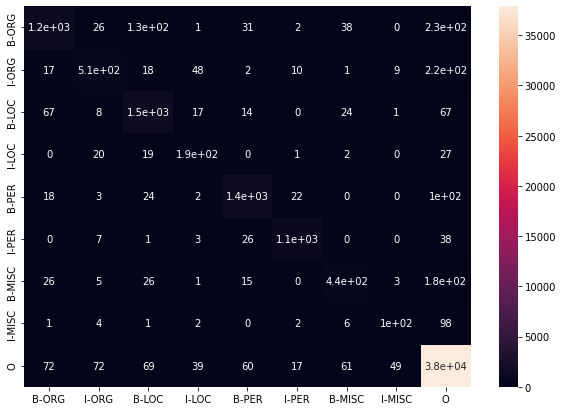

In [35]:
model_path = "model_with_f1.ckpt"
inference(model_path)

0.7543443538099245
              precision    recall  f1-score   support

       B-ORG       0.85      0.68      0.75      1661
       I-ORG       0.79      0.57      0.66       835
       B-LOC       0.82      0.88      0.85      1668
       I-LOC       0.67      0.68      0.67       257
       B-PER       0.90      0.88      0.89      1617
       I-PER       0.95      0.91      0.93      1156
      B-MISC       0.73      0.56      0.63       702
      I-MISC       0.52      0.36      0.43       216
           O       0.97      0.99      0.98     38323

    accuracy                           0.95     46435
   macro avg       0.80      0.72      0.75     46435
weighted avg       0.95      0.95      0.95     46435



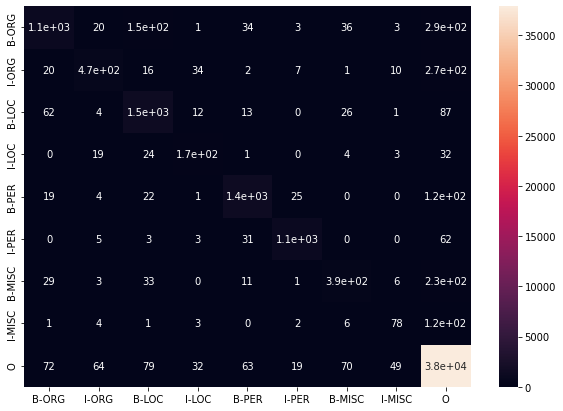

In [84]:
model_path = "model.ckpt"
inference(model_path)